# Introduction

At the time of writing this tutorial, the world is now 10 months into one of the deadliest viral outbreaks in modern history.  Severe Acute Respiratory Syndrome Coronavirus 2, aka COVID-19, is hospitalizing 10's of thousands of people every day.  Much of the U.S is on lockdown, meaning business are open in a limited capacity and citizens are being asked to only leave their homes sparingly and to wear masks when outside.  This has led myself and many others to partake in quarantine induced upskilling. This notebook is an attempt to branch out from my comfort zone in Petroleum Engineering and the application of data science thereto.  I will attempt to use data science to examine the genome of the COVID-19 virus, and attempt to tell the genomic story of our great invisible adversary.

To prepare for this project, I watched a series of biology videos on Khan Academy to give myself a refresher. College bio was a very long time ago! I won't be covering the basics in this notebook, so please take some leisurely time and refresh yourself. It was pretty fun!

https://www.khanacademy.org/science/biology

# National Institute of Health - Genbank

Lets begin by actually downloading the genome of Covid-19. The largest public resource for genomic information is the NIH's Genbank, which contains sequenced DNA.  To make things easier, I'm just going to copy and paste the COVID-19 genome directly from the site linked here: https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2?report=fasta

Downloaded nucleotides for 12,760 samples from https://www.ncbi.nlm.nih.gov/labs/virus/vssi/#/virus?VirusLineage_ss=Severe%20acute%20respiratory%20syndrome%20coronavirus%202%20(SARS-CoV-2),%20taxid:2697049&SeqType_s=Nucleotide&Completeness_s=complete&Region_s=North%20America

In [166]:
using Pkg
# Uncomment to install missing packages
#Pkg.add("Requests")
#Pkg.add("HTTP")
#Pkg.add("CSV")
#Pkg.add("DataFrames")
#Pkg.add("FastaIO") # For FASTA file format parsing. FASTA format is the NCBI sequence format.
Pkg.add("PyCall")
#Pkg.add("FASTX")
using HTTP
using CSV
using DataFrames
using Dates
#using FastaIO
using FASTX

   Updating registry at `C:\Users\Bleep\.julia\registries\General`
  Resolving package versions...
  Installed libpng_jll ──── v1.6.37+6
  Installed MbedTLS_jll ─── v2.16.8+1
  Installed EarCut_jll ──── v2.1.5+1
  Installed HDF5_jll ────── v1.10.5+7
  Installed xkbcommon_jll ─ v0.9.1+5
No Changes to `C:\Users\Bleep\.julia\environments\v1.5\Project.toml`
Updating `C:\Users\Bleep\.julia\environments\v1.5\Manifest.toml`
  [5ae413db] ↑ EarCut_jll v2.1.5+0 ⇒ v2.1.5+1
  [0234f1f7] ↑ HDF5_jll v1.10.5+6 ⇒ v1.10.5+7
  [c8ffd9c3] ↑ MbedTLS_jll v2.16.8+0 ⇒ v2.16.8+1
  [b53b4c65] ↑ libpng_jll v1.6.37+5 ⇒ v1.6.37+6
  [d8fb68d0] ↑ xkbcommon_jll v0.9.1+4 ⇒ v0.9.1+5
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1278
┌ Info: Precompiling FASTX [c2308a5c-f048-11e8-3e8a-31650f418d12]
└ @ Base loading.jl:1278
[ Info: Compiling bit-parallel GC counter for LongSequence{<:NucleicAcidAlphabet}
[ Info: Compiling bit-parallel mismatch counter for LongSequence{<:NucleicAcidA

In [99]:
#The file i've downloaded contains metadata for all 12,760 complete sequences. "Accession" is the unique ID.
sequence_list = CSV.File("./Data/sequences.csv",dateformat="yyyy/mm/dd") |> DataFrames.DataFrame

12760×12 DataFrame. Omitted printing of 10 columns
│ Row   │ Accession │ Release_Date         │
│       │ String    │ String               │
├───────┼───────────┼──────────────────────┤
│ 1     │ MW127503  │ 2020-10-19T00:00:00Z │
│ 2     │ MW127504  │ 2020-10-19T00:00:00Z │
│ 3     │ MW127505  │ 2020-10-19T00:00:00Z │
│ 4     │ MW130859  │ 2020-10-19T00:00:00Z │
│ 5     │ MW130860  │ 2020-10-19T00:00:00Z │
│ 6     │ MW130861  │ 2020-10-19T00:00:00Z │
│ 7     │ MW130862  │ 2020-10-19T00:00:00Z │
│ 8     │ MW130863  │ 2020-10-19T00:00:00Z │
│ 9     │ MW130864  │ 2020-10-19T00:00:00Z │
│ 10    │ MW130865  │ 2020-10-19T00:00:00Z │
⋮
│ 12750 │ MT039888  │ 2020-02-11T00:00:00Z │
│ 12751 │ MT027062  │ 2020-02-07T00:00:00Z │
│ 12752 │ MT027063  │ 2020-02-07T00:00:00Z │
│ 12753 │ MT027064  │ 2020-02-07T00:00:00Z │
│ 12754 │ MT020880  │ 2020-02-05T00:00:00Z │
│ 12755 │ MT020881  │ 2020-02-05T00:00:00Z │
│ 12756 │ MN994467  │ 2020-01-28T00:00:00Z │
│ 12757 │ MN994468  │ 2020-01-28T00:00:00Z │
│ 12758 │ MN997409  │ 2020-01-28T00:00:00Z │
│ 12759 │ MN988713  │ 2020-01-25T00:00:00Z │
│ 12760 │ MN985325  │ 2020-01-24T00:00:00Z │

In [100]:
#Here we convert the datestrings to dates
sequence_list[:Release_Date] = map(x -> Date(x[1:10],Dates.DateFormat("yyyy-mm-dd")), sequence_list[:Release_Date]);

In [101]:
# Notice the inconsistency of the location information. Sometimes no state, sometimes a city no state, some times a city and state
for loc in unique(sequence_list.Geo_Location)[1:5:200]
    println(loc)
end

USA: Montana, Ravalli county
USA: Washington,King County
USA: AR
USA: MI
USA: NV
USA: KS
USA: CO
USA: OH
USA: WY
USA: Virginia
USA: Georgia
USA: Wisconsin, Marquette county
USA: Wisconsin, Milwaukee county
USA: New York, Nassau county
USA: New York, New York county
USA: New York, Putnam county
USA: CA, San Francisco County
USA: Wisconsin, Waukesha county
USA: Wisconsin, Walworth county
USA: Pennsylvania, Philadelphia county
USA: MA, WORCSTER (HORRY)
USA: Wisconsin, Eau Claire county
USA: Connecticut
USA: Wisconsin, Ozaukee county
Guatemala
USA: Washington,Whatcom County
USA: Washington,Benton County
USA: Washington,Walla Walla County
USA: Cruise_Ship_1, California
USA: IA
USA: South Carolina, Richland
USA: Arizona, Maricopa county
USA: Illinois, Dupage county
USA: South Carolina, Berkeley
USA: Wisconsin, Vernon county
USA: Wisconsin, Winnebago county
USA: Colorado, El Paso county
USA: Washington,Jefferson County
USA: Washington, Pierce County
USA: Washington, Cowlitz County


In [104]:
covid = readentry(FastaReader("./Data/refseq.fasta"))[2];

Now, Lets get rid of the useless information. Also, whats with the repeating "a" at the end? Lets clean this data up.

In [105]:
newline_regex = r"(\n)"
covid = replace(covid, newline_regex=>"");

In [106]:
length(covid) # There are 29903 Nucleobases

29903

It's important to note that COVID-19 is a single strand RNA Virus. RNA does not have Thymine, but instead has Uricil. The T's in the genome above can be replaced with U's.

In [107]:
covid = replace(covid, "T"=>"U");

In [108]:
U_count = count(x -> x == 'U', covid)
A_count = count(x -> x == 'A', covid)
G_count = count(x -> x == 'G', covid)
C_count = count(x -> x == 'C', covid)

println("U count: $U_count")
println("A count: $A_count")
println("G count: $G_count")
println("C count: $C_count")



U count: 9594
A count: 8954
G count: 5863
C count: 5492


In [109]:
using Plots

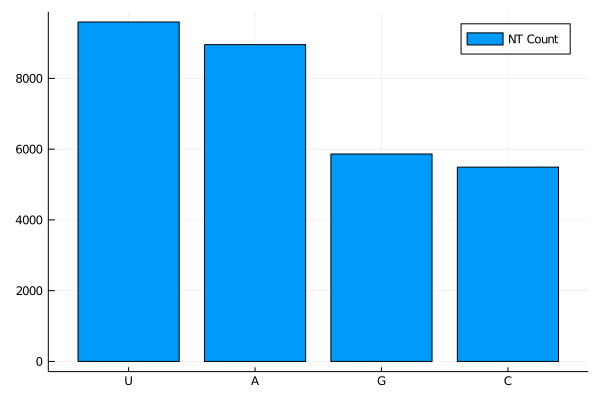

In [110]:
bar([U_count, A_count, G_count, C_count], label="NT Count")
Plots.xticks!(1:4,["U","A","G","C"])

Now, lets convert our genome into Amino Acid form by substituting the nucleotideswith an amino acid labels using a dictionary to map them.

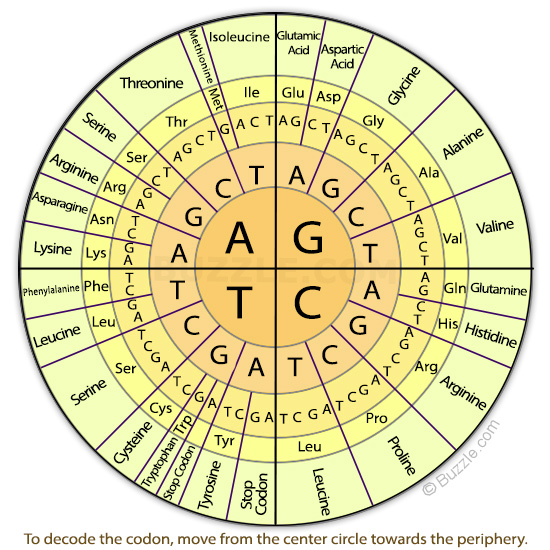

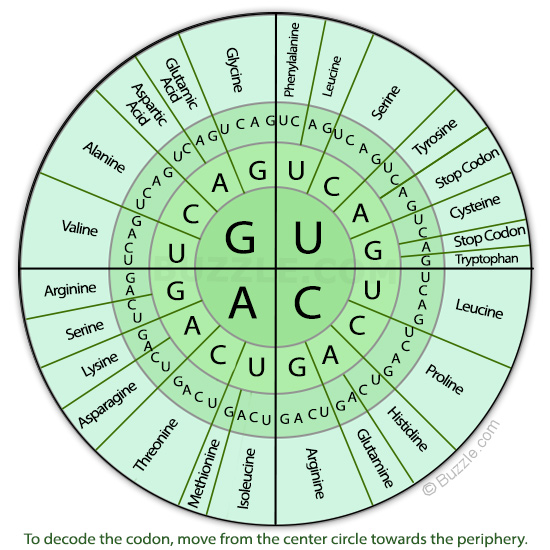

In [93]:
# This is going to suck. I'm going to create a map from every codon to its amino acid by hand!!! ARGH!
amino_dict = Dict(
    "GCU" => "A",
    "GCC" => "A",
    "GCA" => "A",
    "GCG" => "A",
    "GCN" => "A",
    "CGU" => "R",
    "CGC" => "R",
    "CGA" => "R",
    "CGG" => "R",
    "AGA" => "R",
    "AGG" => "R",
    "CGN" => "R",
    "AGR" => "R",
    "CGY" => "R",
    "MGR" => "R",
    "AUU" => "N",
    "AAC" => "N",
    "GAU" => "D",
    "GAC" => "D",
    "AAU" => "B",
    "AAC" => "B",
    "UGU" => "C",
    "UGC" => "C",
    "CAA" => "Q",
    "CAG" => "Q",
    "GAA" => "E",
    "GAG" => "E",
    "CAA" => "Z",
    "CAG" => "Z",
    "GGU" => "G",
    "GGC" => "G",
    "GGA" => "G",
    "GGG" => "G",
    "CAU" => "H",
    "CAC" => "H",
#   "AUG" => "Start",  START is also M
    "UAA" => "Stop",
    "UGA" => "Stop",
    "UAG" => "Stop",
    "AUU" => "I",
    "AUC" => "I",
    "AUA" => "I",
    "CUU" => "L",
    "CUC" => "L",
    "CUA" => "L",
    "CUG" => "L",
    "UUA" => "L",
    "UUG" => "L",
    "AAA" => "K",
    "AAG" => "K",
    "AUG" => "M", # M is also START
    "UUU" => "F",
    "UUC" => "F",
    "CCU" => "P",
    "CCC" => "P",
    "CCA" => "P",
    "CCG" => "P",
    "UCU" => "S",
    "UCC" => "S",
    "UCA" => "S",
    "UCG" => "S",
    "AGU" => "S",
    "AGC" => "S",
    "ACU" => "T",
    "ACC" => "T",
    "ACA" => "T",
    "ACG" => "T",
    "UGG" => "W",
    "UAU" => "Y",
    "UAC" => "Y",
    "GUU" => "V",
    "GUC" => "V",
    "GUA" => "V",
    "GUG" => "V")

amino_fullnames = Dict("")

Dict{Any,Any}()

In [94]:
# Now lets translate our codons into amino acids!

function aminoTranslation(sequence::String;frameshift::Integer = 0, printseq=false) # We introduce a frameshift keyword variable to run on various frames.
    if frameshift > 2 || frameshift < 0
        println("Invalid Frameshift. Must be between 0 and 3")
        return
    end
    aa = ""
    k = 1
    for i in 1 + frameshift:3:length(sequence)-2 - frameshift
        if printseq
            println("$i " * sequence[i:i+2] *"   "* amino_dict[sequence[i:i+2]] *  " $k")
        end
        aa *= amino_dict[sequence[i:i+2]]
        k+=1
    end
    return aa
end

aminoTranslation (generic function with 1 method)

In [95]:
#split(aa,"Stop")
#aminoTranslation(covid[266:13483])
aa =[]
for i in 0:2
    push!(aa,aminoTranslation(covid; frameshift=i,printseq=false))
end

In [97]:
aa

3-element Array{Any,1}:
 "IKGLYLPRStopZTBZLSISCRSVLStopTBFKICVAVTRLHAStopCTHAVStopLITBYCRStopZDTSBSSIFCRLLTVSSVLZPIISTSRFRPGVTERStopDGEPCPWFZREBTRPTZFACFTGSRRARTWLWRLRGGGLIRGTSTSStopRWHLWLSRSStopKRRFASTStopTALCVHZTFGCSBCTSWSCYGStopAGSRTRRHSVRSStopWStopDTWCPCPSCGRBTSGLPZGSSSStopERStopStopRSWWPStopLRRRSKVIStopLRRRAWHStopSLStopRFSRKLEHStopTStopZWCYPStopTHAStopAStopRRGIHSLCRStopZLLWPStopWLPSStopVHStopRPSSTCWStopSFMHFVRTTGLYStopHStopEGCILLPStopTStopAStopBCLVHGTFStopKELStopIADTFStopBStopIGKEIStopHLZWGMSKFCISLKFHBZDYSTKGStopKEKAStopWLYGStopBSICLSSCVTKStopMZPBVPFBSHEVStopSLWStopBFMADGRFCStopSHLRILWHStopEFDStopRRCHYLWLLTPKCCCStopBLLSSMSZFRSRTStopAStopSCRIPStopStopIWLEBHSSStopGWSHYCLWRLCVLLCWLPStopZVCLLGSTCStopRStopHRLStopPYRCCWRRFRRSStopStopZPSStopBTPKRESZHZYCWStopLStopTStopStopRDRHYFGIFFCFHKCFCGBCERFGLStopSIZTBCStopILWStopFStopSYKRKSStopKRCLEYWStopTEIBTESSLCICIRGCSCCTIBFLPHSStopBCSKFCACFTEGRYBBTRWBFTVFTETHStopCYDVHIStopFGYStopZSSCBGLHYRWCCSVDFAVABStopHLWHCLStopKTZTRPStopLAStopREVStopGRCRVSStop

In [44]:
for substr in split(aa[1],"Stop" )
    if substr != ""
        println(string(length(substr)) * " " * substr)
    end
end

8 IKGLYLPR
13 ZTBZLSISCRSVL
14 TBFKICVAVTRLHA
5 CTHAV
7 LITBYCR
35 ZDTSBSSIFCRLLTVSSVLZPIISTSRFRPGVTER
46 DGEPCPWFZREBTRPTZFACFTGSRRARTWLWRLRGGGLIRGTSTS
9 RWHLWLSRS
7 KRRFAST
21 TALCVHZTFGCSBCTSWSCYG
12 AGSRTRRHSVRS
1 W
22 DTWCPCPSCGRBTSGLPZGSSS
2 ER
5 RSWWP
8 LRRRSKVI
7 LRRRAWH
2 SL
8 RFSRKLEH
1 T
5 ZWCYP
3 THA
1 A
9 RRGIHSLCR
5 ZLLWP
4 WLPS
2 VH
7 RPSSTCW
12 SFMHFVRTTGLY
1 H
7 EGCILLP
1 T
1 A
8 BCLVHGTF
3 KEL
5 IADTF
1 B
5 IGKEI
24 HLZWGMSKFCISLKFHBZDYSTKG
4 KEKA
4 WLYG
11 BSICLSSCVTK
12 MZPBVPFBSHEV
3 SLW
9 BFMADGRFC
8 SHLRILWH
3 EFD
15 RRCHYLWLLTPKCCC
13 BLLSSMSZFRSRT
1 A
5 SCRIP
8 IWLEBHSS
18 GWSHYCLWRLCVLLCWLP
9 ZVCLLGSTC
1 R
3 HRL
12 PYRCCWRRFRRS
3 ZPS
13 BTPKRESZHZYCW
1 L
1 T
25 RDRHYFGIFFCFHKCFCGBCERFGL
6 SIZTBC
3 ILW
1 F
6 SYKRKS
7 KRCLEYW
27 TEIBTESSLCICIRGCSCCTIBFLPHS
28 BCSKFCACFTEGRYBBTRWBFTVFTETH
6 CYDVHI
3 FGY
21 ZSSCBGLHYRWCCSVDFAVAB
6 HLWHCL
6 KTZTRP
2 LA
3 REV
6 GRCRVS
6 RRLGBC
7 IYLBLCL
13 BCRWTBCHLCKGB
7 GECSDIL
3 ACK
6 IFGFVC
7 LYHYWWS
1 T
5 SLEFR
14 BICHALKGIVZKV

24 LCLLSFGSHLBCKIIMKLVTPKRT
5 BFLFS
5 ESSZL
18 LHFTKBVVYSHVLBIBHM
16 LMTRVLFTSILBGILE
7 ELEBZHL
41 LBCAWMRLVLBHPFSTSISVIIZFPVYLLZLIARBLBWVVL
9 CVVRSMKTF
8 SIMTFVLF
7 ISSKRTB
2 BV
22 WTPKSAKCTPHYVWWTLRFBWZ
20 PEWRTZWGAIKTTSAPRFTZ
16 YCVLVHRSHSTWZGRP
9 IPSRTRRSB
2 HZ
3 ZSR
15 PBWLLPKSYZTBSWW
1 R
25 BERSZSKMVFLLPRBWARSWTSLWC
9 ZRRHHMGCB
16 GSLEYTKRSHWHPZSC
36 ZCCBRATTSSRBBIAKRLLRRREZRRZSSLFSFLIT
12 SZZFKKFBSRZZ
5 GBFSC
6 BGWZWR
8 CCSCFAAA
5 ZIEPA
5 EZBVW
10 RPTTTRPBCH
4 EICC
2 GF
9 EASAKTYCH
30 SIZCBTSFRZTWSRTBPRKFWGPGTBZTRB
43 LZTLAABCTICPZRFSVLRBVAHWHGSHTFGBVVDLHRCHZIG
13 ZRSKFZRSSHFAE
2 AY
10 RIZBIPTBRA
7 KGZKEEG
23 BSSLTAETEETABCDSSSCCRFG
12 FLZTIATIHEZC
27 LBSGLBSCRPHKADGLYKRFRFSVYDI
9 STLVZBEFS
8 LHSTSRCS
1 L
15 SHIAIFBZCVTLGRT
43 KSHHIFTEATRSTIECTVBBARESCLYGRALMCKIBFSSAIPM
1 F
16 LLRRMTKKKKKKKKKK


I found this website which details the amino acid sequences and start and stop codons.

In [9]:
Amino Acid / Start-Stop Codon	Codon (Nucleotide Triplet Combinations)
Phenylalanine (Phe)	(UUU, UUC)
Leucine (Leu)	(UUA, UUG, CUU, CUC, CUA, CUG)
Methionine (Met) / Start Codon	(AUG)
Valine (Val)	(GUU, GUC, GUA, GUG)
Serine (Ser)	(UCU, UCC, UCA, UCG, AGU, AGC)
Proline (Pro)	(CCU, CCC, CCA, CCG)
Threonine (Thr)	(ACU, ACC, ACA, ACG)
Alanine (Ala)	(GCU, GCC, GCA, GCG)
Tyrosine (Tyr)	(UAU, UAC)
Histidine (His)	(CAU, CAC)
Glutamine (Gln)	(CAA, CAG)
Asparagine (Asn)	(AAU, AAC)
Lysine (Lys)	(AAA, AAG)
Aspartic Acid (Asp)	(GAU, GAC)
Glutamic Acid (Glu)	(GAA, GAG)
Cysteine (Cys)	(UGU, UGC)
Tryptophan (Trp)	(UGG)
Arginine (Arg)	(CGU, CGC, CGA, CGG, AGA, AGG)
Glycine (Gly)	(GGU, GGC, GGA, GGG)
Isoleucine (Ile)	(AUU, AUC, AUA)
Stop Codon	(UAA, UAG, UGA)

LoadError: syntax: extra token "Acid" after end of expression

LoadError: UndefVarError: P not defined

In [11]:
Amino Acid / Start-Stop Codon	Codon (Nucleotide Triplet Combinations)
Phenylalanine (Phe)	(TTT, TTC)
Leucine (Leu)	(TTA, TTG, CTT, CTC, CTA, CTG)
Methionine (Met) / Start Codon	(ATG)
Valine (Val)	(GTT, GTC, GTA, GTG)
Serine (Ser)	(TCT, TCC, TCA, TCG, AGT, AGC)
Proline (Pro)	(CCT, CCC, CCA, CCG)
Threonine (Thr)	(ACT, ACC, ACA, ACG)
Alanine (Ala)	(GCT, GCC, GCA, GCG)
Tyrosine (Tyr)	(TAT, TAC)
Histidine (His)	(CAT, CAC)
Glutamine (Gln)	(CAA, CAG)
Asparagine (Asn)	(AAT, AAC)
Lysine (Lys)	(AAA, AAG)
Aspartic Acid (Asp)	(GAT, GAC)
Glutamic Acid (Glu)	(GAA, GAG)
Cysteine (Cys)	(TGT, TGC)
Tryptophan (Trp)	(TGG)
Arginine (Arg)	(CGT, CGC, CGA, CGG, AGA, AGG)
Glycine (Gly)	(GGT, GGC, GGA, GGG)
Isoleucine (Ile)	(ATT, ATC, ATA)
Stop Codon	(TAA, TAG, TGA)

LoadError: syntax: extra token "Acid" after end of expression

# From this point and Beyond I'm coding up my own Bioinformatics following along a Coursera Bioinfomatics class and Book [Add DETAILS]

In [63]:
using Plots
using Statistics

In [112]:
using LinearAlgebra

In [1]:
ncl = "AGAACACACCTCTTGAACTGAATGAAGGAGAGTTGGAGAGTTCCTCTTGAACTGAATGAAACTGAATGAACCTCTTGACCTCTTGAACTGAATGAAGGAGAGTTGGAGAGTTACTGAATGAATCGTGCCTTCGTGCCTGGAGAGTTACTGAATGAATCGTGCCTCCTCTTGACCTCTTGACCTCTTGAGGAGAGTTGGAGAGTTTCGTGCCTAGAACACAAGAACACAACTGAATGAAACTGAATGAATCGTGCCTAGAACACATCGTGCCTAGAACACAGGAGAGTTCCTCTTGACCTCTTGAGGAGAGTTACTGAATGAAAGAACACAAGAACACACCTCTTGAGGAGAGTTCCTCTTGACCTCTTGAGGAGAGTTTCGTGCCTGGAGAGTTTCGTGCCTTCGTGCCTTCGTGCCTAGAACACAGGAGAGTTACTGAATGAACCTCTTGACCTCTTGAGGAGAGTTGGAGAGTTGGAGAGTTACTGAATGAAACTGAATGAAACTGAATGAAACTGAATGAATCGTGCCTGGAGAGTTCCTCTTGATCGTGCCTGGAGAGTTACTGAATGAATCGTGCCTACTGAATGAAAGAACACATCGTGCCTACTGAATGAAGGAGAGTTGGAGAGTTGGAGAGTTGGAGAGTTGGAGAGTTAGAACACATCGTGCCTGGAGAGTTTCGTGCCTCCTCTTGAAGAACACACCTCTTGAACTGAATGAACCTCTTGAAGAACACAACTGAATGAAGGAGAGTTCCTCTTGAACTGAATGAACCTCTTGAAGAACACATCGTGCCTAGAACACAGGAGAGTTGGAGAGTTCCTCTTGACCTCTTGAAGAACACAGGAGAGTTACTGAATGAAAGAACACAAGAACACACCTCTTGAGGAGAGTTACTGAATGAACCTCTTGAACTGAATGAACCTCTTGAAGAACACACCTCTTGAGGAGAGTTGGAGAGTTTCGTGCCT"
pattern = "TAATTGATA"

"TAATTGATA"

In [2]:
function CountPattern(text::String, pattern::String)::Int64
    """
        CountPattern(text::String, pattern::String)
        
        Compute the number of occurances of `pattern` within `text`
    
        `text` : a string through which you want to count the occurances of pattern
        `pattern`: the desired string patter you wish to count within text
    
        returns Int64
    """
    count = 0
    for i in 1:(length(text) - length(pattern))
        if text[i:(i+length(pattern))-1] == pattern
            count += 1
        end

    end
    return count
end
println(CountPattern(ncl,pattern))

0


In [3]:
function PatternLocation(text::String, pattern::String)
    locations = []
    for i in 1:(length(text) - length(pattern))
        if text[i:(i+length(pattern))-1] == pattern
            push!(locations,i)
        end
    end
    return locations
end

PatternLocation (generic function with 1 method)

In [4]:
function FrequentWords(text::String, k::Integer; worddict=Dict())
    worddict = worddict
    for i in 1:length(text) - k
        kmer = text[i:i+k-1]
        if kmer ∈ keys(worddict)
            push!(worddict[kmer],i:i+k-1)
        else
            worddict[kmer] = [i:i+k-1]
        end
    end
    return worddict
end


FrequentWords (generic function with 1 method)

In [5]:
function merFrequency(text::String, k::Integer)
    worddict = Dict()
    for i in 1:length(text) - k
        kmer = text[i:i+k-1]
        if kmer ∈ keys(worddict)
            worddict[kmer] += 1
        else
            worddict[kmer] = 1
        end
    end
    return worddict
end

merFrequency (generic function with 1 method)

In [6]:
@time kmers = FrequentWords(ncl,11)

  0.005962 seconds (10.15 k allocations: 544.541 KiB)


Dict{Any,Any} with 254 entries:
  "CGTGCCTGGAG" => UnitRange{Int64}[132:142, 380:390, 526:536, 550:560, 668:678]
  "AGGAGAGTTAC" => UnitRange{Int64}[304:314, 426:436, 848:858, 890:900]
  "TGAGGAGAGTT" => UnitRange{Int64}[186:196, 302:312, 344:354, 368:378, 458:468…
  "ACAGGAGAGTT" => UnitRange{Int64}[278:288, 424:434, 806:816, 846:856]
  "CCTTCGTGCCT" => UnitRange{Int64}[128:138, 400:410, 408:418]
  "CACAACTGAAT" => UnitRange{Int64}[225:235, 737:747]
  "CTCCTCTTGAA" => UnitRange{Int64}[689:699]
  "CTTGAAGAACA" => UnitRange{Int64}[694:704, 728:738, 780:790, 836:846, 930:940]
  "GTGCCTCCTCT" => UnitRange{Int64}[159:169, 685:695]
  "TGGAGAGTTTC" => UnitRange{Int64}[196:206, 386:396, 674:684, 958:968]
  "GTGCCTGGAGA" => UnitRange{Int64}[133:143, 381:391, 527:537, 551:561, 669:679]
  "GTTGGAGAGTT" => UnitRange{Int64}[32:42, 102:112, 194:204, 466:476, 474:484, …
  "GACCTCTTGAG" => UnitRange{Int64}[179:189, 295:305, 361:371, 451:461]
  "CTTGACCTCTT" => UnitRange{Int64}[74:84, 168:178, 176:186

In [7]:
_, pos = findmax([length(x) for x in values(kmers)])

(13, 220)

In [8]:
collect(keys(kmers))[pos]

"AACTGAATGAA"

In [9]:
@time [[k,length(kmers[k])] for k in keys(kmers)]

  0.093006 seconds (158.29 k allocations: 8.450 MiB)


254-element Array{Array{Any,1},1}:
 ["CGTGCCTGGAG", 5]
 ["AGGAGAGTTAC", 4]
 ["TGAGGAGAGTT", 7]
 ["ACAGGAGAGTT", 4]
 ["CCTTCGTGCCT", 3]
 ["CACAACTGAAT", 2]
 ["CTCCTCTTGAA", 1]
 ["CTTGAAGAACA", 5]
 ["GTGCCTCCTCT", 2]
 ["TGGAGAGTTTC", 4]
 ["GTGCCTGGAGA", 5]
 ["GTTGGAGAGTT", 11]
 ["GACCTCTTGAG", 4]
 ⋮
 ["GTTTCGTGCCT", 4]
 ["TAGAACACATC", 2]
 ["ATCGTGCCTCC", 1]
 ["GAACACATCGT", 4]
 ["CCTGGAGAGTT", 5]
 ["CTTGATCGTGC", 1]
 ["CCTCTTGAAGA", 5]
 ["ATGAAAGAACA", 3]
 ["TGACCTCTTGA", 7]
 ["GAGTTGGAGAG", 11]
 ["GAAGAACACAT", 1]
 ["TCTTGATCGTG", 1]

In [11]:
function PatternToNumber(pattern::String)
    num = 0
    nucleodict = Dict("A"=>0,"C"=>1,"G"=>2,"T"=>3)
    for (i,nt) in enumerate(pattern)
        num += nucleodict[string(nt)]*4^(length(pattern)- i)
    end
    return num
end

PatternToNumber (generic function with 1 method)

In [12]:
PatternToNumber("ATGCAA")

912

In [13]:
function NumberToPattern(Number::Int64, pattern_length::Int64)
    rvnt_dict = Dict(1=>"A", 2=>"C",3=>"G",4=>"T")
    num = Number
    str = ""
    for i in 1:pattern_length
        str = string(str,rvnt_dict[mod(num,4)+1])
        num = div(num, 4)
    end
    return reverse(str)
end

NumberToPattern (generic function with 1 method)

In [14]:
NumberToPattern(5437,8)

"ACCCATTC"

In [15]:
function ReverseComplement(Pattern::String)
    str =""
    nt_map = Dict("A"=>"T","T"=>"A","G"=>"C","C"=>"G")
    for letter in Pattern
        str = string(str, nt_map[string(letter)])
    end
    return reverse(str)
end

ReverseComplement (generic function with 1 method)

In [16]:
ReverseComplement("AAAACCCGGT")

"ACCGGGTTTT"

In [17]:
gnm = "GACCAGCTACAACCCCCCGCGGATACACGACGAAATTTATCGGTAATTGATGAGGATGGCAAAGCACCCTGACTCATGCGACTCGTCCCCAATTGTCTCCTGCTTGTTGATATTAGATCGGGGCGCCTAAGCGTCAGAATGCAAACGTATCTCTTGGTTTGTCGAGTCAAACTCCGGTCTTCTTGAACATATATGCAGTCGCATCCCTAGGGGCTACTTTCACGCTGATGATTTTTAGATCGTTGAAGCGATTAGCCTCAGTGAATCCGTGCGCTCTGCCCGTTCTATTGGGCCTCCAGGGGATGGCAAAACTAATGGTATCCCCTGGGGATACTCTGAAGCGGTTAGCGAGCCTCTTTTAAGTAAATACGGCAGTGAGTCCCTTTGCTTGGCTGGAGCGTGTCACCCTTTCGCTAGTCTCATCCCCGGGCCGCAACAGCTAAAGACCTCGTGATCTATGCTAACGCCTAGCCGCCATGCTTATCTAAGAAACATGTGGCCTGGCATATGGCAGAGGAATAGCTCGAGAGTGGTGTGTAGGTACTTCCTATCGCCGATACGTCTCGATATTTAGCTTCCCGCGCTAAACGTGCCTCGTCTGGCTACGAGATTCGCCCTCTATACTGTCACAACCGCCCAGGTTGCAATGGATAGTATCAGCCGCGATTGTTTGTTAGGAACTGGATCACTTGTGCTTTCCGCTATCTGGGCGGGCAGTGACGACCAGACGGAGAGCTGTTCCGCGGTCCGGCGTGTCCGTGTACCCTGGCTTACTACGCCAAAAACAGCACTGATTACGTCCGGACGATGGCGGCTGTTATACTTGGGACATATTACCACAATTGGAGCACCCGCCCATCGGCGACCGATTGGGGTCGAGATAACGAGCTACGCGCTCCTATCGATTATGCTACCACCTGAGATTGCGTTCGTGTTAGGTACGTCTGCGGAAATTTTGTCTATTAATGTGAAATGATCAAGGGTTATGGGTGCCATATGTTTTCGGCGCGGACTTAAAGAAACAAGTTACTGCCTTTGTCCGCCGCGCCACAGTTGAGCATTGGCTAGTAGGATAGAGAAGTTAGTAACCTACGAGAGACCTCGATTATCGTCCCTGTCCCTGCCCCTGACATCAACTTCAGAGGGAAAAATATTTGAACTCTTACGACGGATAGGCTCGATTGCGTCCACTTTTTCAGGCCGTGATGATTGTGGTGTAATGACGTTCTGGCCCGGCTGATGAAAAACGTTAGCGGCAGTTTTGCTGGGTTACACACTCTCTTGACGTTTTGGCTATGTTCTCAAATAAAGAATGGGCATATCCTCCAGGGCGCTTCGACCCAAGTTTGAGTAACTCAACGGCAACACTGAGCCGCTCAAATACCATGACCGCCGGGGTCGTTTGGTTAAGCGCTGGCAATACAATCTATCTATTAGAGCATTCTCAATAGATTTCCGCACGGTGAGTTGATCCGTATTGTGAAGATCAGGGCTGTACTTGAGGTTGCCGACCCACGCCATTAGAGCTTCAGTTAATTAAAATGTCAAGTGTGTGCGTGAATCACTAAGTTCTAGATATATTAAACGATGTTGCACGTACCCCTAGCTAGAGCAATCGTCGGAGGGGTATCTTGTCTGGAGCAGGCGGCAGTTCAATACAAGAGCTGACCAACGTTTCGTATCTGCATCAAGCACCGACGAGTTAGCCGCCGCGCAAAGCTGTCAAATCATGGCGTTGCCACCTCCAAACTGGTAATAGTGATTGGCACGTATAGCAACGTAGTACGTAGACAGCCCCTAATTATCTCTATAACTCTGAAGACCAGTTACGCACTACCAACATTAACACCACCCACGCATGGAAAGGTTCAGTATCCGCACGTAAATTGATCGTCAGTAACTAGGCCCGCTCGGTATACCCAGGGGGCAATGGGCCGCGATGTTTCAGGTTTACGGTCGTCGATGCACCTTGCAGCGCTGCCATGGCGCTGTGGCCAGCTACTCTCACAACACCGTTCAGGATGGAAATCCGTCCTCGCCTCGGCTGTCGAACCTGCATTGCTAACTTCTCAGCCACTACCGTCGAAGCCTAAACCAAATCGCGGCGTTCCTTTAGCCGCATCCCACGGCGGAATGGACGCAAGCACGCGTTAACGCCTTTAGAACCATTTGTACCCACCTATTATTTCTATACGTAGCCCGACGGGCTTACGTTCGTGTTATCTGATCATGTATAGGGCTTACCTAGTGCTGAACGGGACGCTAAAGCCAGTCATCGACACTTCGCACCAGAGGCCTTACTTGAAGTGAGAATAATTCCACCCACGCGTTAATCCTGTATGGACGTGCTCGTACACTCGACAAAGATCTACTGCGTGACCCCAAGACCTCCGTGATCGCCGTAAAATTTTACGGCCACAATGCCAGGTAACGACTAGGGCAGTCGGACGGCAGTGACGTACCACGTACGATGGGGCCGATCCTAGTTACGCCTTCTTGGTGTGAACAAAACGCTCTAACGAGGAAGCTGGTCAAGAGCTATGAGGTCGGCACAAGGAGATTTTGTATTCTAATGGAATCGGATGATATCCGTCGGTGTCTCTCCAGTCATTTCAAGCCCGGGTTCCAGCGAAGATTCAATAGGATTAAGAACGTGTCGCGGGTGCGTGCATAGGGGCAGAGTGTACCTTGAGCGTAATGAGTTTAGACATCCTGAGTAGGACACCATTATGGATAAGCGTCACTTAATATTAGCATGCAAAAAAACGACGAGAAACTTACGGATGATGCTTTTGGTAAAATGTACATAGCGATGGTGATTACAACGCAATAGACCGTGTCCACGCAGTTGTCTCGATTCTGCCTGAAATCTACACAACTCGGCTCTGCCACGGTGCACTGGAAAAAGGAGGTCCGCTGAGTGTCGCCTAATACACCGAGGTTCAGGATAACTATGCAAGGCTTACGTGTGAGGCAACCTCTTTCCGGCCTACCGCGACAGCTCAGTGACAACTGTAGATAGTGGCAGTACCCCTCGCATTGGTCCCCTATCGGCAGTAACACGACCCTACATTTCGACGTCGTTCGCGAACCCCCTACGAACATCCCGAACGCCCCACGGAATGCTGATCAGGCGTCCTACTGAGGGGTCAGAAAGCATATCTAAACTTAAACATATAGTCCCAGGTTAACAGTCTTTGGGGCCCCCGTAACCTCATGTGGTCTCCTGTGGCTCAATCCCGGCACTCGCTATCAAATCGTCCATCCGCAACTGTATTTCTGCGGAAATCTGTGCAATTCTTAGGGTAATAATTTTGGCGCTACCTATGTGCGGACCAGCGGGAACCACCTGCCCCGGCTGCTAATACCGCGTCGGCTTTACTATGGGGACGTTTGGAGTGGCGGCGGCCGTCTGTCCGGATTGCGGACTGTAGGTTCGACTATCAACGACTCAACATACTGATACTGGCACAATCACTATCGATTTGAGAACGTAGAAGCACTGTGTAAGGTCCGGAGGCTGTGGCGGTGTACAGAGGCGAGACCTACGCGAAGGAGGCGATGATTGCTAAAATGGTCGTTATTTCCCAGTCGCATGAGGCGTCGCGCAGTTAGGGGCCAAAACTGCAACGACATGTTAGCAACTATAAACTCGGAGACCCAATAAAGAGTGCCAGCATTCGTGAAGGGTGTTTATACATGGCCGGATATCTTGTCCGCACGCCAGGGCCGCGACAGCTTAAATACCTTACTTCCTACCTTCGGCCCGAGAAGGCTTGAATTCTGCAAATCTCTACGTAGGCAGATGTTTTGGGGGACCGGAGTTTCAAACTTCGCGAATAGTCGTGGACCGTAGGTCCGCCATCAGACACCTTCGCGTACCAGGTTCGATGCGGATACAGACAAGGGTGAAACGCAACGCCATGTGTACAGTAGGGCTACATCTTCCAGTTCTCAGTCGGTAGATAGCTGAACAAAACCCTTTGTTTCCGAACAGTTTGCGAGACTTATGTCAAATACCGGATAAGCCTCCACCTAACCTTTCTAGCCTGTGAGTGGGTGTCAAGCGTTTTACCTAGTCCGTAAATGTTAACTATCTTTAACTAATATATCCGTCTTGTAGCAGTCGACGGTATCCCCGGAACCTTCGTGTCTATGAACCGTCGACGAGGATGCGTGCATTGTCTAAGCAGAGATCCGAACAACTTCAAGAACTCAGGGACGCTAAGAGATACACGAATCCTGATATGCCACCGAACGAAATTATGTGACAATCTGTCCGGCCACCTGGTTTGCCAGAGACTCATGATACTCCTCGTAGGTACACACGAAAGTTCAAACCAAATTTCAAATCACCGATCCCCGTTTACTGGATTTTATCCCAGTATGTCATGTGCAGAGTAGTAGCGGTAACGGACCATTGGTGATGCGTAATCGCTTCGTGACCTCGCTGAGGGGTTTTTCTAAAAGTGGTTTACATCTATCCGGATGTGTCGCACCCAGCTCCTTCACGAACGACTTGCCTAGTAATCACTTTATTTTCGCCACATATGAACTGGATAGGCGTGCCACGTGTATCACCGTGAGTATCATGAAGGAGGCTTGTCCAACCGTACCAGGGCGCCCTGTCAGCATGCGACACTACAATGGCGAACAAGCATAACCATCCTTCGTGATGACAGATGCAGCCAGGCGCAGCTCGTAGCTCCGGGTCGGGTTTATTACCGAAAACGTGCGACTACAAAGAAACAATCTTGTGCACAGATCACACTTTATCCGCGTCTCAGATTTGCCCAGGATGTCGCGTTACGTAACAATTAAGGTCTGCTATACGACCGAAGTTAGCACTACGCAGCTTGTGCGCTAAACAAAGAGCTGTAGACACCCCGCGGTGATTGAGCCTAGACTAACGGATTTTAAGGAGATACCGTCTCGCGCCGGTATGCTAAATGGAGACCTCGCGGATGAGTGTGTACGAACACGCTCGTGACGTTTGCGCGCCTGGAGCTCCCGAGGATGGATGGCTAATCCGGCATAAGTACGCTAGTGCCAATTTGCATGTTCAAACCTTTTGTTTAATCCGTCGGAATGGTTCATATCCGCTTACATGCCTGCGCGCGTGCCGCTAGAAACGGGGCGCCGGTGGCGCTGAATTTTATGGGGATGACAAACGGTACCTCCATCGGTGGGGTGAAAACAATTTGAGGACTCCCACCTTTTGTCCATAATACGAAAAGAGGATACCACTGGCAAGGCTTCTTAGTATCCACTACAATTCGAATTTGAAGGAGACACCAATCAGCCCAGGAAAAACGTTGCAACTTGAGTCGGAGAGCCTGACGCCCATATAGAATGACCTAAAAGCGAATGTGATATTTGATCCGTACACCTCATTACACTCTGTGCCACGCCTGTAGTTAATAGCTGCCCCTCAATAGTTACAGAGTTTACTCGAGACTTACCAGTGGAGTTCTACATCTCCAAGTTATGCGCTCTCGAGGCTCCTTCCGGGCCGTCGTCCACGGTGAACGGTCGATACCTCGGTAATCCTCAGCGACCAAATGGGCAGCTTCTCATGCTTCATTGCGGTAAGAATTAAACTGCACCTTTGCCCTCCCAGAACCTCCGCCCCAGTATCTAAAGAAAATGTTAAAATCGAGGCGAACGTAACATCGATAGCGCGGTTATCACTCGCCGCAGGTCGTTACCAAGTGGCCACCAATTCTCACGCTCGTCGTTGTAAGTCATCGTATGTACGGCAGTGAAGGCATCAGGCTTACCTACTCCTGCAAACTCTTTTCACGTCATGGAGGGTCTAACGCTGTGTGAACAAACGTCATCCCTATACCATGGCGCACGCATTCGGCGAGTGCAAGCTCGTCGATTCACCGCCGTGGGCGTACCCTGCCAGCTTCGGGCCTTGTAATTACCTGGCACTTACTTCGGCGTCCTTGGTTCGTCGAACTAGAACCAATCCGGGCCCGGTACCCAATGACCCTCATAGATCAATTGGGGACCACCCACAAGGGAAGGCAGCACTGCGCCGGGTAATGAATCCAACTCGGCGGGATCAATGACGGCTATCCGTTTCCGATATTCAATAGCTAAGTGTTGGGTTAAGGGAATCTGCCATGTTGGGGGATAGGTGAATGGGGGCTGGTCGCTTGGCGGTCGGACTAAGTATGCTGGGGATATATCTTCCAGTCCTCAGTATTAATCGACGCCCAACAAATAAAGCCGAGATCTCGAGTGAAAATAGTCTGATATATACAAAATGCGGGTTACACACTTGGAAAGGACTTAACTGTTAATTGTCGGAAGCGCGGACGTGAACACATAAGCGACTCCATGCGGCAGACGTGGAATGGGCGTGCCTATCCCCCGAGTGCTCTATATCTGTCTGTCGGGAGATGTTAAGTTCTATACCTCCCGGACTGAACTCTAGTACCTGTAATAATTCAGGGTCATTGCTGTGAGGAACCGCTCTTTCAATCATAGTTCGCCTTGCGTAAAGTGCATTGAGTGATAGAGGTTATACCGTACAACTGAGGATCGTGTTATCTATAACTGAGGGGAATTAGATCTCTGGTGCTGCACTTCAGGTTTTTGCTAGCCAATTATGGGGCCGTATTAAAAATTCCGGCAACAAAATCACAATGACTTAGGTAGGTATCAGTTACGAGCCATGGGACTATGCGTTCCGCAAGTTTCTGATCCGAGCAGTATATAATAGGGTAAGAGGCTTATGTCGCTGTTGCTACGGGGGAAAAATTTTCCGGTCAAATTGAGGCGACCCATACTAAAGCCACTTCAGTAGAGCATACACACTGACCGGTATCTGATGCACGTTCTTATTCTCAACTGTAAGGGAGAAATAAGGTCTATGTTGGGTTTTTCGTATGATCTGGCATCTAGGGTACGTAGATCGTACCCAGGGTGGTCCAAACTGTCTGCTTACTCGCGCTAACGCCAGGCACGCACACTGACCCTTGTGGAACTGATAGCCTTACCCTGGCAAATTACCAGGTCTGTAGCTACCCTATTCTGCGAGGCAGTGTGGCTCAACAACTGGGTCACTCGTCTCTGGGGCAGGCGGTGCGTCCGGCCAGGGACGGGTTAAGAATGATCATCGCCAAGTGACGCGTGGGCAAATCCGTGAACTGCCGTCGAGAAACTAGACCATAAAATCAAACCTAGTAATACTCGAGGCAATGGAAGCATAGGCAGTGCGCGTGAACTGGCCTGTAGGCGCTACCTATTTCGTTAGGACCACCACAGTTCATCTTCTGCAATAAGTATTTAAATAGAAGATAGCACCCATTCTTGAGCGATCGAATTTGCTCAACAGTCGGTCTGGTCCCGGCGCCGGCGGTACTAGTCGATTCATAACCTCAAAGAGCTTAGGGCCCGAGTTTACGGTGGTCCTGCATAGGGGTACATAAATGAGCAGCGACGTCAACCACGGCCCCATTCGCTGATACACTCCGTCTGATTATGAAAACCAAAGAATAACTTAGACATCGGCTGGCCGTATGTGTGCTGAGCGGAGCCGCCTCTAAGATTGGTTTATGCCTTGTAAGGAGGACGTTATTGTACCCGCGGCCCTCCCGTGTGAACCCTTTCGTGTGCGCTGGACACCGGCAAGTGACAGCGCAGAATCGGGTCCCGGTCCACTAAGCAGGTCCAAGAGTACTTCTATTCAAGGTGCTGTGGTGATTCCTGCAAAGGTCACGCTTGACCGGCAATTTATATCATAGCTCAAGTCATAGCGAGTTAACGCATGTACGACACAAACGGGCGTAACCAGGACTATACTGTATTGCTGGACACATATGTCCTAGGCCAGACCGATGTACTCCCTAGGTGGTCTCTCAAGTAAGACCGCGCTTTCTATACCAGTGAGTTACCGTCTCGCAAAATCTTAGTCGGCTCACCTTAAAGACGTTAAGTTCGGCACCTTTAATAATCGTTGGAATCTGCGTATCAGTTTGCCACGGAAACACCCGACACCAAACTCCAAGTCCAAGCCCTTGGACGTGCGAGCAAGCCCCGATTGCCCCGCCGTTCCGCGATGTGCATTAGTCGTTTCCGAGGCTTGAAGATCACAATGCCTCGGACTAGACTCAACCGCCGCAACCTTAAATGGACCCTATTGGCAAACTCCTGTGCCCCTTGACATCAACGTTCTGACCCGCAAAGTTGCCAATCATCCTCATGAAAAATTTAGCCCCACAGCGGTCAGTCAACCGCAGCTCAGAACACCAGTCCTACATTGGTGCTACCATCAGAAGATATGCATGCCATATTGGTATGTCTCCGCTTGTTCAATTAGGTTCTAGGCAGATACGGCCTTATCTGTGATGACCATCTTGTGTCGGATATGTACGTTCCGCCGAGCAGTACTCGCTCAGACGGTTGAGCTACCTAGAGCCATATGTCCACATGCAGCGTGCAGTCGCTATGGTCCGCATTAACCAATCATGCAACGCAGCAACAGTGTTTTCTTCGTCTGTTCAACTTCCGACCGCGCCATTAGTAACTACACGTGCATCTCACAAGGCTGATGCTTATGTTCAGGGCCAGAAGGAAGTGAATGCTCGAGCTCCAATGTACCAGCTTTTGTTGACCCTGACGGTATCGAGGTTATAAATGGCCCCTGGGCACAGCTTCTAGTAAGGCCCGATTGCTGCGAGAATCCAGCAACAGAAGCGACCGTTGGTCGTACTCAGAGGCTTGTTTATCCGGGTGTTTATCCACGAAATTCTAGCAGTGGGCCCTTGGCTTGTCTACCTCTGCCGGCTGAACCCCTGCGCGCGGTTGGTCTTGTAGGGGTGTTACTGTGAGCTCCCTTAGTTACGACCGCCAATAGAGGTCGGTTTTGCTGTATCGCGTGGCCTATTCTTTCGCCTGGATACCCAGCTGGTTTTAAGTCTCACTAGTTTCATTTGACGGCACGTCGGAATAGCAAGTTGCTTAGCCGGAGGCGGTTTCACTGACCGGTTAGAAATTCAACCACATAATGAACGACGCATTACTAATATGTGCGGTCAATAAGTTGCTAGGGGGACTTGTGGTCCGGGATCAAACTTAGAACGGGCGAAACGATATGGTAGGTAGCCTCCGCGTG"
ReverseComplement(gnm);

In [45]:
genome3_5 = "GGCCCCAATACACGGCCTGAGGGCCTGAGGCCTGATGGCCTGAGGCCTGAAAGGGCCTGAAAGGCCTGAGAAAAGTGGGCCTGATGGCCTGAACGGCCTGAGGCCTGATATACCTGCGGCCTGACAGGGGCCTGATAGGCCTGATGGCCTGAAGGCCTGATGGCCTGAGGCCTGAACGGCCTGATGGCCTGAGGCCTGACTGGCCTGAGGCCTGAGAGAGGGGCCTGAATATGGGGGCCTGACGGCCTGAGGGCCTGAGGCCTGAGGCCTGAAGGGGCCTGAGGCCTGAGGCCTGAAGGCCTGAGGCCTGAGCAAGGCCTGATGCGGCCTGACTGGCCTGAGGCCTGAACGGGGCCTGACAACCGTTGGCCTGATGGCCTGACGAAGCCTAGGAGGGCCTGAAGGCCTGAGCGGCCTGAGGCCTGAAAGCTCACGAGGGCCTGAGGCCTGACCAGGGCCTGACCGGGGCCTGAGAATCTAAGGTGGCCTGAACAGGCCTGATGAGGGCCTGATGGCCTGATCGGCCTGAGATTCGGCCTGATCTGGCCTGACGGGCCTGAGGCCTGAGGCCTGAACGTTCAGGCCTGAACGGCCTGAGACTAGGCCTGAGGGCCTGAGGCCTGACGGGCCTGAGGCCTGAGGGCCTGACACTTACCGGCCTGAGGCCTGACGGCCTGATTTGGCCTGATGGCCGGCCTGAAAGCTGGCCTGAGTGGCCTGAATGGCCTGAACATGGGCCTGAAGGGCCTGAGGCCTGAGGCCTGATAGGCCTGATGTGGCCTGAGGCCTGAAGGGCCTGAGGCCTGAGTCTGGCCTGACAGGCAGATCGGGCCTGAAAAACAATCTCGTCCGCAAGGCCTGACCGGGCCTGAAGAGGCCTGAACGGCCTGAGGCCTGAGGCCTGAAGGGCCTGATTGGCCTGACATTAGGCCTGACAAGGGCCTGAGGCCTGACCCCTAGTGGCCTGAGGCCTGATGCGGCCTGAGAGGGCCTGAGGCCTGAGATAGGCCTGAGGCCTGAACAGCGGGCCTGACCACCTACGGGCCTGAGCGGCCTGATGGCCTGAGGCCTGAATAGGTCGGCCTGAGGCCTGAGCGGCCTGAGGGCCTGACGGCCTGAGGCCTGACCGGCCTGAGGCCTGAGGCCTGATTAGAGTCGGGCCTGATACAATGGCCTGACGGCCTGATGGCCTGAAGGCCTGAAAGGCCTGACAGGCCTGAGGCCTGAGGCCTGAGGCCTGATGGGCCTGAACGATAGGGGCCTGAATGCATAGGGCCTGACTGCTGAAATCAGTGGCCTGATCGGCCTGACGGCCTGACGGCCTGAGCCGGCCTGAGTCCGGCCTGAGCTAGGCCTGAGGCCTGAGGCCTGAGGGGGCCTGAAGGCCTGATGGCCTGACAGGGCCTGAGGCCTGAATTGGCCTGAGAAAATAGGCCTGAGGCCTGACGGCCTGAAAATTCTGTATAAAGGGCCTGAGCGGCCTGAGGCCTGAAAGGCCTGAGGGCCTGAGGCCTGAGGCCTGAGGCCTGAGGCCTGAGGCCTGAACTAGGCCTGATCGGCCTGAGGCCTGAAGGCCTGAGGCCTGACGGCCTGATGGCGGGCCTGACAGGAATGGGAAAGGCCTGACCTTGGCCTGAAGAGGGACCCCCTCGGCCTGATCATTAGGCCTGACAGGCCTGATTCTTGCACCGTCAGGCCTGAACCGGCCTGACGGCCTGAGGTATGATAATAGGCCTGACGGCCTGAAGGCCTGACTGCGGGCCTGATTTTAGGCCTGATTAAGGCCTGAGGCCTGAGGCCTGATGGTGGCCTGATGAGCTGGCCTGAACCGTGCGGGCCTGAGCGGGGCCTGACTGGGCCTGATTTTCCGGCCTGAGGCCTGACTGGCCTGAGGCCTGACGGCCTGAGACCGGGCCTGAAATAGGCCTGAGTGGTAGAAGGCCTGACGGCCTGACGGCCTGAGGGCCTGATTAGGCCTGAGGCCTGACGGCCTGAGGCCTGACGGGCCTGAGGCGATCCGGCCTGAGGCCTGAGGGCCTGAGGCCTGAGGGCCTGATGTGGCCTGAGGCCTGAGAGGGCCTGAGGCCTGAGGGCCTGAATGCGGCCTGAGGGCCTGAGGCCTGATTTATTGGCCTGAAACTCAGGCCTGAGGCCTGATCGGCCTGAAATAAAGGCCTGATTTGGCCTGATGGCCTGAACCGCAGGCCTGAGGGCCTGAGAACCGGCCTGAAGGGCCTGAGGCCTGATGGCCTGATTGGCCTGAGGCCTGAGGCCTGACGTGGCCTGAAGGCCTGAGGCCTGAATCAGGAGGCCTGATCAGGCCTGAGGCCTGACGGCCTGACGGGCCTGACGGCCTGATCGGCCTGAAACCTGGGCCTGACTATTCGGTACCCGGCCTGACCGGCCTGAGTCGGCCTGAGGCCTGAGGCCTGATCGGCCTGAGAGGCCTGAAGGGCCTGAAGGCCTGATGACGAGGGGCCTGAGGCCTGAGGCCTGAGGGCCTGACGGCCTGATATAGGGCCTGAAAGGCCTGAGCATCCGGGCCTGAGGCCTGACGGCCTGAGGCCTGAGGCCTGATATGGGCCTGATGGCCTGAAGGCCTGAGGCCTGATGTGGCCTGAAACAACACGGCCTGATATAGGGCCGCCCAGGGCCTGACCAGGCCTGAGGGCCTGAAGGCCTGAATTTGGCCTGAGGCCTGACAGGCCTGAGGCCTGACGAAGGCCTGAGGCCTGACCGGGGCCTGAGGGGCCTGAGTGGCCTGAGGCCTGAGGCCTGAAGGCCTGATCTTTGGGCCTGAACGGCCTGAGAGGCCTGAGATGGCCTGACGAACGGGCCTGAGGGCCTGAGGCCTGAACAGGGCCTGAGTGGCCTGAATCGGCCTGAGGCCTGAGGCCTGAAAGACAGCACGGCCTGACATGGCCTGATCCACCGGCCTGATATGGGGCCTGATCTACGTGTTGGCCTGACGGCCTGACGGCCTGACCGGCCTGACTAGGCCTGATGGCCTGACAGGCCTGAATTGGCCTGACCCGGCCTGATGGCCTGAGGCGGCCTGAGGCCTGAATGGGCCTGAGGTGCGGCCTGATAGGCCTGAGGGCCTGACAGATGGCCTGAGGCCTGAATCAACGGCCTGATACGGCCTGAGCCTAATCCGAGGGCCTGAACGGCCTGAGGCCTGATGGCCTGAGGCCTGATCTGGCCTGAAGGCCTGAAGGCCTGAATCTCTGGACGAGGCCTGAATCTCGCAGGGCCTGAGGCCTGAGGCCTGATGCGGCCTGACTGGCCTGAAGGCCTGAGCGAGGCCTGAGGCCTGAGGCCTGAGTATGACAGGGCCTGAACGGCCTGAAGGCCTGAGGCCTGAGGCCTGAGGGCCTGACTAGCTGGCCTGAAGGCCTGACTGGCCTGATGGCCTGATACCCAGAGGGCCTGACTAAGTAGGCCTGATTGTACCCGGCCTGAGGACGGGCCTGAGGCCTGAGGCCTGAGGCCTGATCAGAGGCCTGACGGCCTGACGTTTGGCCTGAAAGCAAAGAGGCCTGACACGTATACGCCGGCCTGATTCCCTTCGGCCTGATCCCTGGGCCTGAGCCTTCTTTCCGAGGCCTGAACACTGCGCGCGGCCTGACGGCCTGAGGCCTGATACGGCCTGAGGGGCCTGAGGCCTGAAGCGGCCTGATCGGGCCTGACGACGGCCTGAGCCTGGGCCTGAGGCCTGAAAGGGGCCTGAGGCCTGAGCCAAGGCCTGACCTTACTAGGCCTGAAGGCCTGAGGCCTGAGACAGGTGGCCTGATGGCCTGAGGGCCTGACGGCCTGAGCAGCGGGCCTGATTAGGCCTGATAGGCCTGAGGCCTGAGGCCTGAGGGGGCCTGAATCGGCCTGAAGGCCTGAAGGGCCTGAGGCCTGAAAGGGCCTGACGGCCTGATAAGGCCTGAGGTGGCCTGACGGCCTGAGGCCTGAGGCCTGAGTGGGGCCTGACGGCCTGACGGCCTGAAAGGGCCTGATATAGGCCTGATAAGGATGGCCTGACCCAAGAGGCCTGACAAGGCCTGATCGGCCTGATTGGCCTGAGGCCTGAACTGGGGCGGCCTGAGGTCTATCGCTTGCGGCCTGACCTTGGCCTGACGGCCTGACTCACCATCCTTTGGCCTGAGGCCTGAATGAGGCCTGATGTACTTTGTGTTAGAAGCAGGCCTGACGACGGGCCTGAGTAGGGGCCTGACGGGCCTGAGGGAGGGGCCTGAATGGGCCTGAAAGACGGGCCTGATGGCCTGAGGCCTGAACGCAGGGCCTGAGGCCTGACGGCCTGAACGCGGGCCTGATGGCCTGAGGCCTGAGGCCTGAGGCCTGAGCGGAAAGGCCTGAGGGCCTGATTACGAGGCCTGATGGCCTGATAGACTGAGGGCCTGAGGCCTGAGGCCTGAGGCCTGAGAACTGGCCTGAGTCCGGCCTGAGGCCTGAGAGGCCTGACAGGTTCGGCCTGACTTGGGGGCCTGAGGCCTGAGGCCTGAGGCCTGAATGGCCTGATGGGCCTGATTAGGGCCTGACCGGCCTGAGGCCTGAAGTCACCGGGCCTGAACGAGGCCTGATTGGCCTGAGTCGAAGGCCTGAAGGGCCTGAAAGGCCTGATGGCCTGAGGGCCTGAGCGGCCTGAGTATGGGCCTGATCCAAGGGGCCTGAGGGCGGCCTGAGGGCCTGAACGGCCTGAGTGGCCTGAAGGTGGCCTGATATCCATGGCCTGACAGGCCTGATGGCCTGATGGGGCCTGATGGCCTGAGGGCCTGAGTGGCCTGATGCGGCCTGAGAGGATCGGGCCTGACGGCCTGAGGCCTGATGGCCTGAGGCCTGACCGGCCTGAAGGGCCTGAGGCCTGACGGCCTGAGGGCCTGAGGCCTGATGCCCGGGCCTGAGGCCTGAGGCCTGAAGGCCTGATGGCCTGAGAGCAATCGAGGCCTGAGGCCTGAGGCCTGAGGCCTGACGGCCTGAGTGGCCTGATGGCCTGATCGGCCTGAACACAGTGGGCCTGATGGGCCTGATGCATAGGGCCTGAGGCCTGAGCTGGGCCTGACATTAGAAGAGAGGCCTGAACGGCCTGAGGCCTGAGGCCTGACAGGCCTGATGGCCTGACGCGGAGGCCTGATGGGGGCCTGAGGCCTGAGGGGGCCTGAGATGGCCTGACGGCCGGCCTGACGGCCTGAAGGCCTGAATAGGGCCTGAGGCCTGAGCGGCCTGACGGCCTGAACCGGCCTGATAGGCCTGAGGGCCTGATATCGGCCTGAAGGCCTGACTGGCCTGATGTGGGCCTGAGGCCTGAGGCCTGAGCTCACGGCCTGATACAGGCCTGACTTGGCCTGAGGCCTGACATGATAAGGCCTGATCAATGGCCTGATGGCCTGAGGCCTGAGGGCCTGACCGGCCTGACTTCGGAGGCCTGAGGCCTGAACGCTGGCCTGACAGGCCTGATATGGCCTGAGGCCTGAGCGGCCTGACGGCCTGAAGGCCTGATCGGCCTGAGGCCTGAAAGCCCTGAAAGGCCTGAGATACAGGCCTGAGAACGGCCTGACAGGGCCTGAAATTAGGGCCTGAGGCCTGAGGTGGGGGTCTCGTGGCCTGACGGCCTGAGGCCTGAGGCCTGAAGTGGCCTGAGGCCTGAGCATAGGCCTGACGGCCTGAATACAAGGCCTGAGGCCTGACGGCCTGAGCAGGGCCTGACAGGCCTGAAGGCCTGAGGCCTGACGGGGGCCTGAAGGCTCTGGGTAGGCCTGATAGGCCTGAGTGTCGGGCCTGAAACGGCCTGAGGCCTGACGCTTCACGACTCTTGGCCTGAAACATTGCTTCAGGCCTGATGGGGCCTGAAATGGCCTGACGGCCTGAACGGCCTGAGGCCTGATCAGTGGCCTGATGGCCTGACGGCCTGAGGCCTGAGGAGTCCGGGGCCTGAGGCCTGATGGGCCTGAGGCCTGAGGCCTGATCTACAGGGCCTGAAGTCGGGCCTGAAGTGGCCTGAGGCCTGAAACCACGGCCTGAGGCCTGAGGCGCTTAGGAGAGGCCTGAGGCCTGACAGGGCCTGACGACTAGGCCTGACTGCGGGCCTGAATGTGGCGTGGCCTGATTTAGACGCTCTAGGCCTGAGGCCTGACGGCCTGACGCCGGCCTGACGGCCTGAGATGACGGCCTGAGATGGCCTGAGGCCTGAAATGGCCTGAGGCCTGAGAACGAGGCCTGAGGCCTGACAGTCCACACGTAGGCCTGATTTTTGGCCTGATGGGGCAACCTGGCCTGAGGCCTGAGCCAGCACCTCTAGCGGCCTGAATGCTAGGCCTGATGGCCTGAGCCGGCCTGAGGGGGCCTGAGGCCTGATATGTCGGCCTGAGGCCTGAATCATGGCCTGAAGGCCTGACAGAGGCCTGACCGGCCTGATGGCCTGAAAGGCCTGATGGCCTGAAGCTTGACCGGCCTGAGGCCTGAACACATCGGCCTGAGGCCTGAGGGCCTGAGGGCCTGAGGCCTGACGGCCTGAGCGGCCTGACGGCACAGGCCTGATGCATGACGGCCTGACGATTTGGCCTGAGGCCTGACAGGCCTGAGGCCTGAACCGGCCTGAAGTATCGGCCTGACATCGATCGGCCTGACGGCCTGGCCTGACAAGGGTAGGGCCTGAGGCCTGAGGGGCCTGAAGGCCTGAGGCCTGACTCCCAGGCCTGACCAGGCCTGAGGGCTTGACCGGCCTGATCTGGGGCCTGAGGCCTGAATCTATGGAGGGCCTGATGTAAGGCCTGATAGGCCTGACATAGGCCTGAAGGTCGGCCTGAGGCCTGAGGTCGAAGTTACCCATCCAGTCGGCCTGATGTGGGCCTGATTACTAGATCTTGGCCTGACGGGCCTGATCGAACGAGGGCCTGATGGGCCTGACCGGCCTGATGGGGCCTGAGGCCTGATCGGCCTGATGGCCTGAGGCCTGAGGCCTGAGGCCTGACGGCCTGACAAGGCCTGAGGAGGCCTGAGCCGGCCTGACAGGCCGTGAAGAGGCCTGAGGCCTGAGGGCCTGAAGAGGCCTGATAACGGAGCGGCCTGAACCGCGATGGGCCTGAGGCCTGAATGGCCTGACTAATGGCCTGAATGGCCTGATCGGCCTGAGGCCTGAGGCCTGATGGCCTGATGGCCTGAGTGGCCTGAGTGGGCCTGAGGCCTGAGGCCTGAACCCGGCCTGATCGGCCTGAGCGGCCTGAGGCCTGACGCTTGGCCTGAGGGTGGCCTGATGGCCTGAGGCCTGAGGCCTGAGGCCTGACCCCACTAATGGCCTGATGGGCCTGAGGCCTGAGGGCCTGAGGCCTGAAGTGGCCTGAACATAGGCCTGAGTGCAGGGCCTGAGGCCTGAGGCCTGATCGGCCTGAAGGCCTGATAGGGCCTGAAGTGGCCTGACGGCCTGACCGGCCTGAGCAAGACCATGGCCTGATTGGCCTGAGGCCTGAGGGCCTGAGGCCTGAGGTGGGCCTGAAGGCCTGATGGGGTGTGGCCTGATACACGGGGCCTGAGGCCTGATGCGAGGCCTGATGTGGGCCTGATCAGCACGTTCCCGGCCTGAGGCCTGAGGCCTGAAGGCCTGAAGGGCCTGATATGGCCTGATTGGCCTGAGGCCTGAGGCCTGAATGCTATCAGGGCCTGAGGCCTGAACCACGCATGACGGGCCTGAGGGCCTGATGTGGGCCTGAGGCCTGATGGCCTGAACCGGCCTGATCCCGAGCGGCCTGAGTGGCCTGACAAGAAGGCCTGAGTGTTGGCCTGAGGGGTTGGCCTGATTTCCCTCCGGCCTGAGGCCTGATACGTAAGGGCCTGAGAACTGGCCTGAGGCCTGAGGCCTGAGGCCTGAGCGGCCTGAACTATGGCCTGAGAGGCCTGAGGCCTGAGTGGCCTGAAGGAGTCTGGCCTGAGGCCTGAAGGGGCCTGAGGCCTGATGGCCTGACTTCGGCCTGACGGCTGGCCTGAAATTTGGCCTGACGGCCTGATGGGCCTGACTTGACGAATGGCCTGATGAACACGGCCTGAAGGCCTGAAGGCCTGAGAGGGAGGGCCTGAGGAGGGCCTGAGGCCTGAGGCCTGAAGGCCTGACGGCCTGAGGGCCTGAGGGCCTGAGGGCCTGACAGAGGCCTGAACGACCGGCCTGACGGCCTGACTGCTCTAGGCCTGACGGGCCTGAAGGTCGGCCTGAGGCCTGAGGCCTGACGGCCTGAGGCCTGATGCTCGGCCTGAGGGCCTGAGGCCTGAGGCCTGAAGGCCTGAAGGCCTGAGGCCTGATGCCTGGCTGGCCTGAGGCCTGACCTCGTTGGCCTGAGGCCTGACGGGCCTGAGGCCTGAGGCCTGAGGCCTGATGGCCTGAGGCCTGACGGCCTGATGCCATCGGCCTGAGTAATTATGGCCTGAGTAGGCCTGATCAGGCCTGAGGCCTGAGCGGCCTGAGGCCTGAGGCCTGATTGGCCTGAGGCCTGAAGGCCTGACTGGCCTGAGCGTGGCCTGAGGGGCCTGAGCGGCCTGAGGCCTGAGGCCTGACTAGGGGGCCTGATCGGCCTGATTAGTCTGGGCCTGAGGCCTGAATGGCCTGACTAAGGCCTGAGGCCTGAGGCCTGAGGCTGAGCGAGGCCTGACGTATACCGGCCTGAGGCCTGAGCCGGGCCTGACAGGCCTGAGCGGCCTGAGGCCTGATGGCCTGAAAGGCCTGAAGGCCTGAAAGGCCTGATCGGCCTGACGCGGTTGTGGCCTGATGGCCTGAGGCCTGAGTGGCCTGACTGGCCTGAGTACTTTCTGGCCTGACGGCCTGATGCCCGTAGGCCTGACCGGCCTGACATGGCCTGAGGCCTGAAGGCCTGAGCTCGACGGCCTGAGGCCTGAGGCCTGAATGTTAGAGTCGGCCTGAGGCCTGAGGCCTGAGGCCTGAGGCTCCGGGCCTGATGAGGCCTGAGGCCTGACTCGTCAGGCCTGAAAAGCGCGTGGCCTGATGGCCTGAGGCCTGATGTTGGCCTGAGGCCTGATCTAAAGCCCGTTCTCCCGGCCTGAGGCCTGATCGGCCTGAACGCGCGCAGGCCTGAGGGCCTGAGGCCTGACTATTTGGGGGCCTGAATGACTGGCCTGAGGCCTGACGGAGGGCCTGAGGGCCTGAGGCCTGAGGCCTGACAAATTCGGCCTGACATGAGGCCTGA"
pattern3_5 = "GGCCTGAGG"
println(genome3_5[73:73+length(pattern3_5)-1])
join(PatternLocation(genome3_5,pattern3_5) .-1," ")

AAGTGGGCC


"13 21 36 94 161 185 201 243 251 258 275 282 297 334 412 437 553 560 602 610 626 633 656 744 751 777 793 884 891 939 961 988 1006 1059 1080 1096 1112 1128 1135 1213 1220 1227 1351 1358 1365 1401 1432 1478 1494 1502 1509 1516 1523 1530 1557 1572 1712 1782 1789 1869 1885 1955 1973 1988 2004 2019 2026 2034 2041 2059 2076 2083 2102 2110 2143 2203 2232 2256 2263 2288 2319 2412 2419 2476 2483 2490 2541 2556 2563 2597 2661 2688 2704 2722 2740 2758 2765 2834 2842 2879 2886 3042 3052 3069 3090 3110 3168 3183 3251 3258 3303 3310 3350 3357 3364 3455 3467 3474 3481 3629 3646 3655 3705 3723 3765 3794 3842 3849 3856 3893 3928 3946 3953 4064 4086 4146 4224 4268 4288 4323 4330 4337 4358 4403 4410 4417 4447 4490 4497 4504 4549 4630 4673 4684 4770 4820 4835 4860 4875 4883 4903 4910 4950 4957 4964 5043 5089 5096 5144 5151 5210 5253 5300 5307 5348 5390 5397 5428 5466 5507 5579 5586 5615 5622 5639 5679 5722 5791 5876 5911 5918 5934 5950 5957 6000 6020 6027 6047 6125 6182 6199 6219 6276 6336 6346 6366 6454 

In [19]:
vibrio_cholera_gnm = read("C:\\Users\\Bleep\\Downloads\\random data\\Vibrio_cholerae.txt",String);
pattern_vibrio = "CTTGATCAT"

"CTTGATCAT"

In [20]:
join(join(PatternLocation(vibrio_cholera_gnm,pattern_vibrio) .-1," "))

"60039 98409 129189 152283 152354 152411 163207 197028 200160 357976 376771 392723 532935 600085 622755 1065555"

In [21]:
CountPattern("ACTGTACGATGATGTGTGTCAAAG","TGT")

4

In [19]:
mrfreq = merFrequency("CGGAGGACTCTAGGTAACGCTTATCAGGTCCATAGGACATTCA",3)

Dict{Any,Any} with 31 entries:
  "GAC" => 2
  "CTT" => 1
  "CTA" => 1
  "TTC" => 1
  "ATC" => 1
  "ACA" => 1
  "TAG" => 2
  "GTA" => 1
  "GCT" => 1
  "TCC" => 1
  "AGG" => 4
  "CGG" => 1
  "GAG" => 1
  "AAC" => 1
  "GGT" => 2
  "TCA" => 1
  "TAA" => 1
  "CAG" => 1
  "GTC" => 1
  "ATT" => 1
  "CTC" => 1
  "TCT" => 1
  "CGC" => 1
  "GGA" => 3
  "ACG" => 1
  ⋮     => ⋮

In [20]:
@time filter(x -> x[2] >=3 ,pairs(mrfreq))

  0.022619 seconds (12.31 k allocations: 629.813 KiB)


Dict{Any,Any} with 2 entries:
  "AGG" => 4
  "GGA" => 3

In [21]:
_, pos = findmax([length(x) for x in values(FrequentWords("CGGAGGACTCTAGGTAACGCTTATCAGGTCCATAGGACATTCA",3))])

(4, 11)

In [22]:
collect(keys(FrequentWords("CGGAGGACTCTAGGTAACGCTTATCAGGTCCATAGGACATTCA",3)))[pos]

"AGG"

In [23]:
ReverseComplement("TTGTGTC")

"GACACAA"

In [24]:
PatternLocation("ATGACTTCGCTGTTACGCGC","CGC")

2-element Array{Any,1}:
  8
 16

In [189]:
# Slower Brute force algorithm
function ClumpFinder(genome::String,k::Int64 , L::Int64, t::Int64)
    """
        ClumpFinder(genome::String,k::Int64, L::Int64, t::Int64)
        
        ClumpFinder identifies all distinct k-mers forming (L, t)-clumps in genome
    """
    clumps = Dict()
    for i in 1:length(genome)-L
        mergewith!(max,clumps, merFrequency(genome[i:i+L], k))
    end
    return filter(x -> x[2]>=t,clumps)
end

# Faster algorithm. Finds frequent words first with one pass through genome
# then compares word locations with windows of size L
function ClumpFinder2(genome::String, k::Int64, L::Int64, t::Int64)
    """Julia
        ClumpFinder2(genome::String, k::Int64, L::Int64, t::Int64)
    
        ClumpFinder2 identifies all distinct k-mers forming (L, t)-clumps in genome
        
        
    """
    frequent_words = filter(x -> length(x[2]) >= t, FrequentWords(genome, k))
    clumps = Dict()
    for (k,v) in frequent_words
        clumps[k] = 0
        for i in 1:length(v) - t+1
            clump_count = 0
            for j in i:length(v)
                if v[j][1] <= v[i][1] + L
                    clump_count += 1
                else
                    break
                end
            end
            clumps[k] = max(clump_count,clumps[k])
        end
    end
    return clumps
end
    

ClumpFinder2 (generic function with 1 method)

In [185]:
@time cf1 = ClumpFinder(genome3_5[1:515],10,500,3)

  0.002495 seconds (11.40 k allocations: 683.641 KiB)


Dict{Any,Any} with 34 entries:
  "GAGGCCTGAA" => 6
  "CTGATGGCCT" => 6
  "CGGCCTGAGG" => 4
  "GCCTGAAGGC" => 3
  "GGCCTGAAGG" => 4
  "GCCTGAACGG" => 3
  "AGGCCTGAGG" => 3
  "GGCCTGAAAG" => 3
  "GATGGCCTGA" => 6
  "AGGCCTGATG" => 5
  "GAAGGCCTGA" => 3
  "GCCTGAGGCC" => 14
  "CCTGAGGCCT" => 14
  "GGCCTGATGG" => 6
  "GGCCTGAACG" => 3
  "AGGGGCCTGA" => 3
  "TGATGGCCTG" => 6
  "ATGGCCTGAG" => 3
  "GGCCTGAGGC" => 14
  "TGAGGGCCTG" => 3
  "GAGGGCCTGA" => 5
  "AAGGCCTGAG" => 3
  "GAGGCCTGAG" => 4
  "CTGAGGCCTG" => 14
  "AGGGCCTGAG" => 3
  ⋮            => ⋮

In [186]:
@time cf11 = ClumpFinder2(genome3_5[1:515],10,500,3)

  0.000426 seconds (4.63 k allocations: 182.500 KiB)


Dict{Any,Any} with 34 entries:
  "GAGGCCTGAA" => 6
  "CTGATGGCCT" => 6
  "CGGCCTGAGG" => 4
  "GCCTGAAGGC" => 3
  "GGCCTGAAGG" => 4
  "GCCTGAACGG" => 3
  "AGGCCTGAGG" => 3
  "GGCCTGAAAG" => 3
  "GATGGCCTGA" => 6
  "AGGCCTGATG" => 5
  "GAAGGCCTGA" => 3
  "GCCTGAGGCC" => 14
  "CCTGAGGCCT" => 14
  "GGCCTGATGG" => 6
  "GGCCTGAACG" => 3
  "AGGGGCCTGA" => 3
  "TGATGGCCTG" => 6
  "ATGGCCTGAG" => 3
  "GGCCTGAGGC" => 14
  "TGAGGGCCTG" => 3
  "GAGGGCCTGA" => 5
  "AAGGCCTGAG" => 3
  "GAGGCCTGAG" => 4
  "CTGAGGCCTG" => 14
  "AGGGCCTGAG" => 3
  ⋮            => ⋮

In [168]:
FrequentWords(genome3_5[1:515],10)["GAGGCCTGAA"]

6-element Array{UnitRange{Int64},1}:
 42:51
 167:176
 264:273
 288:297
 340:349
 418:427

In [27]:
@time Dict([k=>v for (k,v) in cf1 if v >=3])

  0.113132 seconds (140.56 k allocations: 7.455 MiB)


Dict{String,Int64} with 34 entries:
  "GAGGCCTGAA" => 6
  "CTGATGGCCT" => 6
  "CGGCCTGAGG" => 4
  "GCCTGAAGGC" => 3
  "GGCCTGAAGG" => 4
  "GCCTGAACGG" => 3
  "AGGCCTGAGG" => 3
  "GGCCTGAAAG" => 3
  "GATGGCCTGA" => 6
  "AGGCCTGATG" => 5
  "GAAGGCCTGA" => 3
  "GCCTGAGGCC" => 14
  "CCTGAGGCCT" => 14
  "GGCCTGATGG" => 6
  "GGCCTGAACG" => 3
  "AGGGGCCTGA" => 3
  "TGATGGCCTG" => 6
  "ATGGCCTGAG" => 3
  "GGCCTGAGGC" => 14
  "TGAGGGCCTG" => 3
  "GAGGGCCTGA" => 5
  "AAGGCCTGAG" => 3
  "GAGGCCTGAG" => 4
  "CTGAGGCCTG" => 14
  "AGGGCCTGAG" => 3
  ⋮            => ⋮

In [30]:
@time filter(x -> length(x[2]) >=2,cf1)

  0.022189 seconds (12.40 k allocations: 633.269 KiB)


Dict{Any,Any}()

In [31]:
genome4_5 = "CTTTTAGAGCTCTGGCGTTGTTGTGGATGGGATACATAAAGAGATCTCATCTAGCAGTAATAAATGAAGGCTAAAGAAGATAACTCTCTACGGATTGCTACGGATTGACTGCAGATTGCGTACGCAGTAGCCCGCATGGTGAGTCTTGTTACGACAACATACGACAACACAACAACAGATATTCAACTCGAATGGTCGAATGTTACCCTAATTACTGTCCGGGCGTGGCGTCTTCTATTCTAGCGTCTTCTATAGACTTCGTCGACTTTGTTGGGCAGGAGGGATGAGTGCAACAAGGTACAGACAAGTGTGCGATTGGCCAGCTTTGGCCAGCTGCCGACGCACTTAAGGAGACTGGCAGGCCGAGAAATTCATCTGCTCAGCTTTCCACGCCGCCATACAACACGGCCATACAACACAAGAGTCTACTCACGTCTCGGAACCAAGAAAAACGCTCCCTTACCGGCACGCCAGCAAGCAGCCTTGTGGGTATCGTGCCGTTGCATGAACGATCCATTTATCGGTGACGGATAACTTATGCTGGCTCTTTAATAAGGGAGTAAGACGTGCGCAGCGCGGTACTAGATACCGCACTACTGGAGGCCCAGCGGGCAGCTTAGGATTGTCTCAGAAAGATACTTTCCACTTAGCAAAAAGTGAATCGAAAGTGAAGTGAATCGTGCTCGCCTTGTAACAGGTTGTTTTCTATCTATGAAACGCAAGTCTGCTTTATAACATATTTGTCATCATTATTCATCAGCGCCAAATCCGTGGCCTCGACGCGTTTTTAGTTCGCGCAACTGAATGCGTTTGCGCAGTGGTTCCTAGCTTTAGCGTCCTCCGCTAAACAGTTCCTTTGCATTAAAGTCCGGACAAATCACCCATTTCGTCTTAATCTGTTGTCGCATGTCCATAGCTTTGAGTTAATAAACCATCCGACTTTGTAATAACAACTTGGCTTGGCAGATAGACATGTGTGGAATAAATCCAGTTACCTTTCGAGCTATCGATATTCCTAAGTCTTCCAGCCCTAACAGTAATACCGGGGCGCCTAGCCTATCCGTTGGGATTGTCTACCAACACACCGGTCTACCAACCTATGATCCATCGTCGGCAGCAGAAGTGCTCAGCACTTATTGTCCTCGCACGAATAGCATAGACTGGCTATCACTGGTCTTAGGCACCTCTTAACCCAAGAGTGCTTCCGTGGAAGTTCGCTACCAAAATAATAAAATAGTCCAATATAGTCCAAGATCCAAGAGGGGAGAGGTGGGCGAAGAGAGTACCTAGCGTAGCATTCTTGTAACTGCACCATCCGGGCTTGTAGACGAGAAATCAGCCGGTTATGATGCGTTAATCCAACTCATACCTTAGCGGCCGCAGCGCATAGTAGCAGGCATGTGTTATATGTTAGAGACTGCTTTGATAGGTATAGCTTACGAGTCCGTCCCATCAATACCGATGCAGTAACAGTAAAGCAATTCGCGGACAAACCCGGACGAGGGCTGGGACGGGACTGCGTGCACTATCATGACGTAGAGTGTCGAGCGAACCGTATTATGTTCGATATGCAGTAGATATCGCTCTAGCGGAGTGTACTCACAGCCATTTCAGCGCCAGCGCCATTTCAGCGCAGAAGAACAGGGCTGGCTATGCGTTACATCCGTGATGATATCCTGATTTGGTGCAAGGCGCAGTCGCCAGGTAATCATTATTTGGGCTATTTGGGCTATTTTGGGCTATAATCGCAAGGCCCCAAAATGTGATATTGATAACGGCGGTTTAAACTGCTCTTAGAATAGTTAAGTTTCCGATTCCTCCCCTCCTGGAAAGCCAAGCGGGATAACCCTCGTCGATTGTGAGTTGCGCC"
@time cf2 = ClumpFinder(genome4_5,10,26,4)

  0.014319 seconds (47.22 k allocations: 4.694 MiB)


Dict{Any,Any}()

In [32]:
@time filter(x -> x[2] >=3,cf2)

  0.022274 seconds (12.29 k allocations: 628.360 KiB)


Dict{Any,Any}()

In [34]:
filter(x -> x[2] >1,merFrequency(genome4_5,10))

Dict{Any,Any} with 19 entries:
  "CCATACAACA" => 2
  "ATTTCAGCGC" => 2
  "GCCATTTCAG" => 2
  "TTGGGCTATT" => 2
  "CATACAACAC" => 2
  "CTACGGATTG" => 2
  "GTCTACCAAC" => 2
  "CCATTTCAGC" => 2
  "TTTGGGCTAT" => 3
  "ATTTGGGCTA" => 2
  "CATTTCAGCG" => 2
  "TGGGCTATTT" => 2
  "AAGTGAATCG" => 2
  "GCCATACAAC" => 2
  "TATTTGGGCT" => 2
  "TACGACAACA" => 2
  "CGTCTTCTAT" => 2
  "TTGGCCAGCT" => 2
  "GCGTCTTCTA" => 2

In [45]:
ecoli = read("C:\\Users\\Bleep\\Downloads\\random data\\E_coli.txt",String)

"AGCTTTTCATTCTGACTGCAACGGGCAATATGTCTCTGTGTGGATTAAAAAAAGAGTGTCTGATAGCAGCTTCTGAACTGGTTACCTGCCGTGAGTAAATTAAAATTTTATTGACTTAGGTCACTAAATACTTTAACCAATATAGGCATAGCGCACAGACAGATAAAAATTACAGAGTACACAACATCCATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCACAGGTAACGGTGCGGGCTGACGCGTACAGGAAACACAGAAAAAAGCCCGCACCTGACAGTGCGGGCTTTTTTTTTCGACCAAAGGTAACGAGGTAACAACCATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAACGTTTTCTGCGTGTTGCCGATATTCTGGAAAGCAATGCCAGGCAGGGGCAGGTGGCCACCGTCCTCTCTGCCCCCGCCAAAATCACCAACCACCTGGTGGCGATGATTGAAAAAACCATTAGCGGCCAGGATGCTTTACCCAATATCAGCGATGCCGAACGTATTTTTGCCGAACTTTTGACGGGACTCGCCGCCGCCCAGCCGGGGTTCCCGCTGGCGCAATTGAAAACTTTCGTCGATCAGGAATTTGCCCAAATAAAACATGTCCTGCATGGCATTAGTTTGTTGGGGCAGTGCCCGGATAGCATCAACGCTGCGCTGATTTGCCGTGGCGAGAAAATGTCGATCGCCATTATGGCCGGCGTATTAGAAGCGCGCGGTCACAACGTTACTGTTATCGATCCGGTCGAAAAACTGCTGGCAGTGGGGCATTACCTCGAATCTACCGTCGATATTGCTGAGTCCACCCGCCGTATTGCGGCAAGCCGCATTCCGGCTGATCACATGGTGCTGATGGCAGGTTTCACCGCCGGTAATGAAAAAGGCGAACTGGTGGTGCTTGGACGCAACGGTTCCGACTACTCTGCTGCGGTGCTGGCTGCCTGTTTACGCGCCGAT

In [46]:
ClumpFinder(ecoli,9,500,3)

Dict{Any,Any} with 1904 entries:
  "GTACTTTCG" => 3
  "GATGCCTGA" => 4
  "ATCCGCCCT" => 3
  "TCTGCGCAC" => 3
  "GCAGAGAAG" => 3
  "GGGGAAGGA" => 4
  "GTGGACAGT" => 4
  "GCACTGGAG" => 3
  "TTTCAATAT" => 3
  "TTTCTTTTG" => 3
  "ATTATTGCG" => 3
  "GGCGCAGGC" => 3
  "CGCTGGCGC" => 9
  "TCAGGCCTA" => 5
  "GTGATTAGC" => 3
  "TGGTGGTGG" => 4
  "GGGCAGCCC" => 3
  "TCACGGTCT" => 3
  "AATATCAGC" => 3
  "TTCTTTTGG" => 3
  "ACCCGAAGG" => 3
  "CCGCCGAAG" => 3
  "CCGCCCTAC" => 3
  "TATCATGCC" => 3
  "GCGGATTCG" => 3
  ⋮           => ⋮

In [52]:
@time filter(x -> length(x[2]) > 3,FrequentWords(ecoli,10))

  3.554135 seconds (14.31 M allocations: 656.617 MiB, 22.30% gc time)


Dict{Any,Any} with 472378 entries:
  "GCAAAACAAA" => UnitRange{Int64}[847558:847567, 1425300:1425309, 2506312:2506…
  "TAATACCTAC" => UnitRange{Int64}[793300:793309, 1702931:1702940, 2021746:2021…
  "TTGCGCTTGC" => UnitRange{Int64}[669023:669032, 981365:981374, 1003458:100346…
  "CCTGGGATAA" => UnitRange{Int64}[874516:874525, 1048318:1048327, 1299471:1299…
  "ATGTTTCAGC" => UnitRange{Int64}[1488597:1488606, 1639976:1639985, 2253414:22…
  "CATTCGTTTG" => UnitRange{Int64}[49277:49286, 1578532:1578541, 2386620:238662…
  "GCCGCTTAAC" => UnitRange{Int64}[323065:323074, 975992:976001, 2043035:204304…
  "GACAAAGAGA" => UnitRange{Int64}[493492:493501, 1389822:1389831, 1635935:1635…
  "TTTAAGTCTG" => UnitRange{Int64}[896504:896513, 2032716:2032725, 3671076:3671…
  "AGCTGGAAGG" => UnitRange{Int64}[3186:3195, 34493:34502, 145733:145742, 44107…
  "GCTTTTCATT" => UnitRange{Int64}[2:11, 1434909:1434918, 1619880:1619889, 1651…
  "ACGCTATTGG" => UnitRange{Int64}[1166239:1166248, 2341449:2341458, 30046

In [62]:
intersect(2:5,7:10)

7:6

In [37]:
testgnm = filter(x -> length(x[2]) > 2,FrequentWords(genome4_5,10))

Dict{Any,Any} with 1 entry:
  "TTTGGGCTAT" => UnitRange{Int64}[1715:1724, 1724:1733, 1734:1743]

In [44]:
for x in values(testgnm)
    println(x[1][1]:x[1][1]+500)
end

1715:2215


In [182]:
@time ClumpFinder("CGGACTCGACAGATGTGAAGAACGACAATGTGAAGACTCGACACGACAGAGTGAAGAGAAGAGGAAACATTGTAA",5,50,4)

  0.000443 seconds (1.36 k allocations: 94.281 KiB)


Dict{Any,Any} with 2 entries:
  "GAAGA" => 4
  "CGACA" => 4

In [183]:
@time ClumpFinder2("CGGACTCGACAGATGTGAAGAACGACAATGTGAAGACTCGACACGACAGAGTGAAGAGAAGAGGAAACATTGTAA",5,50,4)

  0.000058 seconds (202 allocations: 17.297 KiB)


Dict{Any,Any} with 2 entries:
  "GAAGA" => 4
  "CGACA" => 4

Dict{Any,Any} with 2 entries:
  "GAAGA" => 0
  "CGACA" => 0

Dict{Any,Any} with 2 entries:
  "GAAGA" => UnitRange{Int64}[17:21, 32:36, 53:57, 58:62]
  "CGACA" => UnitRange{Int64}[7:11, 23:27, 39:43, 44:48]

In [190]:
merFrequency("CGGACTCGACAGATGTGAAGAACGACAATGTGAAGACTCGACACGACAGAGTGAAGAGAAGAGGAAACATTGTAA",5)["GAAGA"]

4

In [191]:
FrequentWords("CGGACTCGACAGATGTGAAGAACGACAATGTGAAGACTCGACACGACAGAGTGAAGAGAAGAGGAAACATTGTAA",5)["GAAGA"]

4-element Array{UnitRange{Int64},1}:
 17:21
 32:36
 53:57
 58:62